3.6 주택 가격 예측: 회귀 문제
boston_housing
  - 실제 데이터에 대한 상세 기술 : 
    주택의 가격에 영향을 미치는 요소14개의 필드를 가지고 있다
    Crim(자치시 별 1인당 범죄율), ZN(25,000 평방피트를 초과하는 거주지역의 비율),
    INDUS(비소매상업지역이 점유하고 있는 토지의 비율), CHAS(찰스강에 대한 더미변수(강의 경계에 위치한 경우는 1, 아니면 0)),
    NOX(10ppm 당 농축 일산화질소), RM(주택 1가구당 평균 방의 개수), AGE(1940년 이전에 건축된 소유주택의 비율),
    DIS(5개의 보스턴 직업센터까지의 접근성 지수), RAD(방사형 도로까지의 접근성 지수), TAX(10,000 달러 당 재산세율),
    PTRATIO(자치시 별 학생/교사 비율), B(1000(Bk-0.63)^2, 여기서 Bk는 자치시별 흑인의 비율을 말함.),
    LSTAT(모집단의 하위계층의 비율(%)), MDEV(본인 소유의 주택가격(중앙값) (단위: $1,000))

  - 예측하고자 하는 방법/방향 기술 :
    개별적인 레이블을 예측하는 것이 아니라 연속적인 값(1970년대 보스턴 주택가격)을 예측
    
  - 학습을 위해 데이터가 어떻게 가공/처리 되었는지 기술 :
    데이터셋의 특성마다 스케일(값의 범위)가 다르기 때문에 정규화해야한다.
    입력데이터에 있는 각 특성에 대해 평균을 빼고, 표준편차로 나누어준다.
    
  - 사용된 모델의 입력층과 출력층에 대한 기술
    데이터 포인트가 506개로 개수가 적기 때문에 과적합을 피하기 위해서(훈련 데이터가 적을수록 과대적합이 더 쉽게 일어남)
    작은 모델을 사용 하였다. 가용할 데이터가 적기 때문에 K-겹 검증을 사용하였다.

In [1]:
# 3-24 보스턴 주택 데이터셋 로드하기
from keras.datasets import boston_housing
import numpy as np

np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()
np.load = np_load_old

Using TensorFlow backend.


In [2]:
# 3-25 데이터 정규화하기
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [3]:
# 3-26 모델 정의하기
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                          input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [5]:
# 3-27 K-겹 검증하기
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # 검증 세트로 모델 평가
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [6]:
# 3-28 각 폴드에서 검증 점수를 로그에 저장하기
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [8]:
# 3-29 k-겹 검증 점수 평균을 기록하기
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

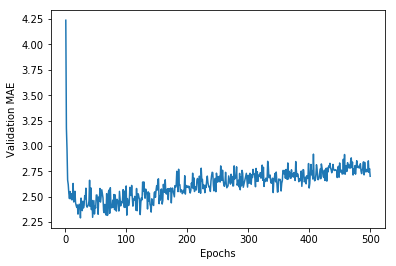

In [10]:
# 3-30 검증 점수 그래프
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

fig5 = plt.gcf()

plt.draw()
fig5.savefig('fig5.png', dpi=100)

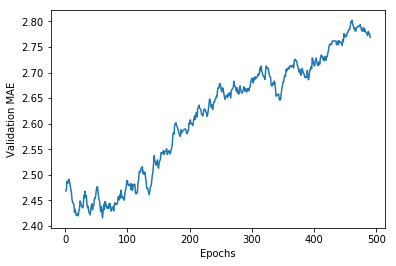

In [11]:
# 3-31 처음 10개의 데이터 포인트를 제외한 검증 점수 그리기
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [12]:
# 3-32 최종 모델 훈련하기
model = build_model()
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print(test_mae_score)

102/102 [==============================] - 0s 1ms/step
2.49778964472752
